In [121]:
import shutil
import os
from PIL import Image
from random import sample
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision.transforms as T
import re
import requests
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.utils import make_grid
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import BCELoss
from sklearn.metrics import classification_report, accuracy_score, auc
from tqdm.notebook import tqdm
from yacs.config import CfgNode as CN
from datetime import datetime
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [122]:
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
r, a

(1279262720, 830912000)

In [40]:
_C = CN()

_C.ROOT_PATH = "../data"
_C.TRAIN_PATH = os.path.join(_C.ROOT_PATH, 'train')
_C.VAL_PATH = os.path.join(_C.ROOT_PATH, 'test')
_C.CLASSES = ['blur', 'demoir', 'haze', 'rain']
_C.BATCH_SIZE = 4

#values for preprocessing
_C.IMAGE_W = 500
_C.IMAGE_H = 500
_C.MEAN = [0.4649, 0.4426, 0.4149]
_C.VAR = [0.2830, 0.2772, 0.2891]

In [41]:
print(os.listdir(_C.TRAIN_PATH))
print(len(os.listdir(_C.TRAIN_PATH)))

['blur', 'demoir', 'haze', 'rain']
4


In [42]:
print(os.listdir(_C.VAL_PATH))
print(len(os.listdir(_C.VAL_PATH)))

['blur', 'demoir', 'haze', 'rain']
4


decoding encoding labels

In [43]:
def encode_label(label, classes_list = _C.CLASSES): #encoding the classes into a tensor of shape (4) with 0s and 1s.
    target = torch.zeros(len(classes_list))
    for l in label:
      if l in classes_list:
          idx = classes_list.index(l)
          target[idx] = 1
    return target

def decode_target(target, threshold=0.5): #decoding the prediction tensors of 0s and 1s into text form
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
          result.append(_C.CLASSES[i])
    if len(result) == 0:
        return "clear"
    else:
        return ' '.join(result)

A class creating dataset from a folder with different types of images, separated by types of degradation, applied to a picture.

In [44]:
# A class to create a Custom Dataset that will load images and encode the labels of those images from their folder names
class myDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        self.images = get_path_names(root_dir)              

    def __len__(self):
        return len(self.images)       
    def im_path(self, idx):
        return self.images[idx]
    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img) 
        
        label = img_path.split('/')[3].split('_')
        if 'clear_gt' in img_path:
            encoded_label = torch.Tensor([0,0,0,0])
        else:
            encoded_label = encode_label(label)
        
        return img, encoded_label, encode_label(label)

A function, that lists all images contained in the folder.

In [45]:
#Making a list that contains the paths of each image
def get_path_names(folder):
  images = []
  for path, subdirs, files in os.walk(folder):  
    for name in files: 
      images.append(os.path.join(path, name))
  return images

defining transforms for training and validation dataset

In [46]:
#setting a set of transformations to transform the images 
train_trans = T.Compose([T.Resize((_C.IMAGE_W, _C.IMAGE_H)),
                      T.RandomHorizontalFlip(),
                      T.RandomRotation(2),
                      T.ToTensor(),
                      T.Normalize(_C.MEAN, _C.VAR)])
val_trans = T.Compose([T.Resize((_C.IMAGE_W, _C.IMAGE_H)),
                       T.ToTensor(),
                       T.Normalize(_C.MEAN, _C.VAR)])

In [47]:
train_dataset = myDataset(_C.TRAIN_PATH, transform = train_trans)
val_dataset = myDataset(_C.VAL_PATH, transform = val_trans)
print(len(train_dataset))
print(len(val_dataset))

30213
7629


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: clear
mask: blur

tensor([0., 0., 0., 0.])
../data/train/blur/clear_gt/real_blur/gt_197.png


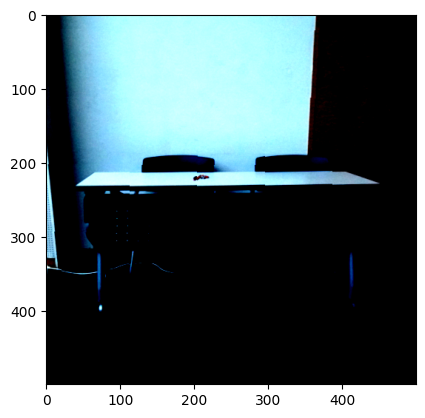

In [48]:
def show_example(img, label, mask):
  plt.imshow(img.permute(1,2,0))
  print("Label:", decode_target(label))
  print("mask:", decode_target(mask))
  print()
  print(label)

show_example(*train_dataset[5000])
print(train_dataset.im_path(5000))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: clear
mask: demoir

tensor([0., 0., 0., 0.])


'../data/test/demoir/clear_gt/image_374.jpg'

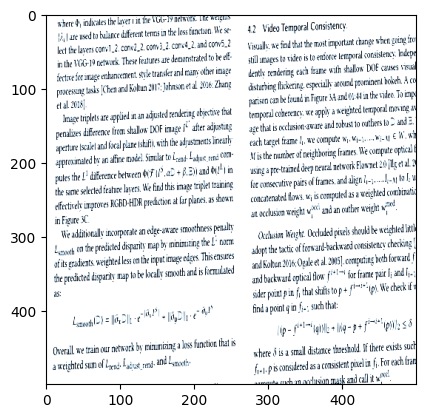

In [49]:
show_example(*val_dataset[3350])
val_dataset.im_path(3350)

In [50]:
train_loader = DataLoader(train_dataset, _C.BATCH_SIZE, shuffle=True, num_workers = 12)
val_loader = DataLoader(val_dataset, _C.BATCH_SIZE * 2, num_workers = 12)

In [52]:
# placeholders
#psum    = torch.tensor([0.0, 0.0, 0.0])
#psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
#for inputs, mask, target in tqdm(train_loader):
#    psum    += inputs.sum(axis        = [0, 2, 3])
#    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

In [53]:
# pixel count
#count = len(train_dataset) * _C.IMAGE_H * _C.IMAGE_W

# mean and std
#total_mean = psum / count
#total_var  = (psum_sq / count) - (total_mean ** 2)
#total_std  = torch.sqrt(total_var)

# output
#print('mean: '  + str(total_mean))
#print('std:  '  + str(total_std))

In [54]:
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
r, a

(0, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


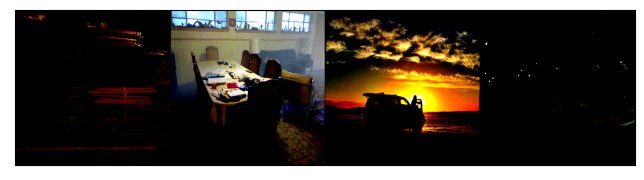

In [56]:
def show_batch(dl, nmax=16):
    for images, masks, labels in dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:nmax], nrow=4).permute(1, 2, 0))
        break

show_batch(train_loader)

In [57]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [58]:
def F_scores(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold
    TP, TN, FP, FN = [], [], [], []
    precision, recall, F2 = [], [], []
    for i in range(4):
        TP.append((prob[:,i] & label[:,i]).sum(0).float())
        TN.append(((~prob[:,i]) & (~label[:,i])).sum(0).float())
        FP.append((prob[:,i] & (~label[:,i])).sum(0).float())
        FN.append(((~prob[:,i]) & label[:,i]).sum(0).float())
    for i in range(4):
        precision.append(torch.mean(TP[i] / (TP[i] + FP[i] + 1e-12)))
        recall.append(torch.mean(TP[i] / (TP[i] + FN[i] + 1e-12)))
        F2_sus = (1 + beta**2) * precision[i] * recall[i] / (beta**2 * precision[i] + recall[i] + 1e-12)
        F2.append(F2_sus.mean())
    return F2

In [69]:
def TFPN(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold
    TP, TN, FP, FN = [], [], [], []
    for i in range(4):
        TP.append((prob[:,i] & label[:,i]).sum(0).float())
        TN.append(((~prob[:,i]) & (~label[:,i])).sum(0).float())
        FP.append((prob[:,i] & (~label[:,i])).sum(0).float())
        FN.append(((~prob[:,i]) & label[:,i]).sum(0).float())
    return TP, TN, FP, FN
def calc_metrics(TP, TN, FP, FN, beta=1):
    precision = TP / (TP + FP + 1e-12)
    recall = TP / (TP + FN + 1e-12)
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return precision, recall, F2

In [70]:
images, masks, targets = next(iter(val_loader))
targets = torch.Tensor([[1., 1., 1., 1.],
        [1., 1., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
preds = torch.Tensor([[1., 1., 1., 1.],
        [1., 1., 1., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
TP, TN, FP, FN = TFPN(preds, targets)
print(calc_metrics(TP[0], TN[0], FP[0], FN[0]))

(tensor(0.3333), tensor(1.), tensor(0.5000))


In [71]:
def BCE_custom(preds, targets, masks):
    losses = F.binary_cross_entropy(preds, targets, reduction='none')
    for i, mask in enumerate(masks):
        for j, val in enumerate(mask):
            if val == 0:
                losses[i][j] == 0
    return losses.mean()

In [81]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, masks, targets = batch 
        out = self(images)                            # Generate predictions
        loss = BCE_custom(out, targets, masks)   # Calculate loss
        del images
        del masks
        del targets
        del out
        torch.cuda.empty_cache()
        return loss    
        
    @torch.inference_mode()
    def validation_step(self, batch):
        images, masks, targets = batch
        out = self(images)                           # Generate predictions
        loss = BCE_custom(out, targets, masks)              # Calculate loss
        score = F_score(out, targets)                # Calculate accuracy
        indiv_scores = F_scores(out, targets)
        TP, TN, FP, FN = TFPN(out, targets)
        del images
        del masks
        del targets
        del out
        torch.cuda.empty_cache()
        return {'val_loss': loss.detach(), 
                'val_score': score.detach(), 
                'val_score_blur': indiv_scores[0].detach(), 
                'val_score_demoir': indiv_scores[1].detach(), 
                'val_score_haze': indiv_scores[2].detach(), 
                'val_score_rain': indiv_scores[3].detach(),
                'TP_blur': TP[0].detach(),
                'TP_demoir': TP[1].detach(),
                'TP_haze': TP[2].detach(),
                'TP_rain': TP[3].detach(),
                'FP_blur': FP[0].detach(),
                'FP_demoir': FP[1].detach(),
                'FP_haze': FP[2].detach(),
                'FP_rain': FP[3].detach(),
                'TN_blur': TN[0].detach(),
                'TN_demoir': TN[1].detach(),
                'TN_haze': TN[2].detach(),
                'TN_rain': TN[3].detach(),
                'FN_blur': FN[0].detach(),
                'FN_demoir': FN[1].detach(),
                'FN_haze': FN[2].detach(),
                'FN_rain': FN[3].detach()} 
    

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine losses and get the mean value
        batch_scores = [x['val_score'] for x in outputs]    
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies and get the mean value
        batch_scores_blur = [x['val_score_blur'] for x in outputs]    
        epoch_score_blur = torch.stack(batch_scores_blur).mean()      # exclusive for blur
        batch_scores_demoir = [x['val_score_demoir'] for x in outputs]    
        epoch_score_demoir = torch.stack(batch_scores_demoir).mean()      # exclusive for moire
        batch_scores_haze = [x['val_score_haze'] for x in outputs]    
        epoch_score_haze = torch.stack(batch_scores_haze).mean()      # exclusive for haze
        batch_scores_rain = [x['val_score_rain'] for x in outputs]    
        epoch_score_rain = torch.stack(batch_scores_rain).mean()      # exclusive for rain
        
        TP_blur = float(sum([x['TP_blur'] for x in outputs]))
        FP_blur = float(sum([x['FP_blur'] for x in outputs]))
        TN_blur = float(sum([x['TN_blur'] for x in outputs]))
        FN_blur = float(sum([x['FN_blur'] for x in outputs]))
        
        TP_demoir = float(sum([x['TP_demoir'] for x in outputs]))
        FP_demoir = float(sum([x['FP_demoir'] for x in outputs]))
        TN_demoir = float(sum([x['TN_demoir'] for x in outputs]))
        FN_demoir = float(sum([x['FN_demoir'] for x in outputs]))
        
        TP_haze = float(sum([x['TP_haze'] for x in outputs]))
        FP_haze = float(sum([x['FP_haze'] for x in outputs]))
        TN_haze = float(sum([x['TN_haze'] for x in outputs]))
        FN_haze = float(sum([x['FN_haze'] for x in outputs]))
        
        TP_rain = float(sum([x['TP_rain'] for x in outputs]))
        FP_rain = float(sum([x['FP_rain'] for x in outputs]))
        TN_rain = float(sum([x['TN_rain'] for x in outputs]))
        FN_rain = float(sum([x['FN_rain'] for x in outputs]))
        
        TP_total = TP_blur + TP_haze + TP_demoir + TP_rain
        FP_total = FP_blur + FP_haze + FP_demoir + FP_rain
        TN_total = TN_blur + TN_haze + TN_demoir + TN_rain
        FN_total = FN_blur + FN_haze + FN_demoir + FN_rain
        
        prec_blur, rec_blur, f2_blur = calc_metrics(TP_blur, TN_blur, FP_blur, FN_blur)
        prec_demoir, rec_demoir, f2_demoir = calc_metrics(TP_demoir, TN_demoir, FP_demoir, FN_demoir)
        prec_haze, rec_haze, f2_haze = calc_metrics(TP_haze, TN_haze, FP_haze, FN_haze)
        prec_rain, rec_rain, f2_rain = calc_metrics(TP_rain, TN_rain, FP_rain, FN_rain)
        prec_total, rec_total, f2_total = calc_metrics(TP_total, TN_total, FP_total, FN_total)
        
        print("blur")
        print(f'prec {prec_blur}, rec {rec_blur}, f2 {f2_blur}')
        print("demoir")
        print(f'prec {prec_demoir}, rec {rec_demoir}, f2 {f2_demoir}')
        print("haze")
        print(f'prec {prec_haze}, rec {rec_haze}, f2 {f2_haze}')
        print("rain")
        print(f'prec {prec_rain}, rec {rec_rain}, f2 {f2_rain}')
        return {'val_loss': epoch_loss.item(), 
                'val_score': f2_total, 
                'val_score_blur': f2_blur, 
                'val_score_haze': f2_haze, 
                'val_score_rain': f2_rain, 
                'val_score_demoir': f2_demoir}    

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}, val_score_blur: {:.4f}, val_score_demoir: {:.4f}, val_score_haze: {:.4f}, val_score_rain: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score'], result['val_score_blur'], result['val_score_demoir'], result['val_score_haze'], result['val_score_rain']))

In [82]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')  


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():  
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device       

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [83]:
#loading training and validation data onto GPU
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)

In [84]:
# checking up the shapes of the datas
for xb, masks, yb in train_dl:
  print(xb.shape)
  print(masks.shape)
  print(yb.shape)
  del xb
  del yb
  torch.cuda.empty_cache()
  break

torch.Size([4, 3, 500, 500])
torch.Size([4, 4])
torch.Size([4, 4])


In [85]:
from tqdm.notebook import tqdm

def save_model(model):
    PATH = os.path.join('saved_models', datetime.now().strftime('%d-%m-%y-%H_%M_dqnweights.pt'))
    torch.save(model.state_dict(), PATH)

def load_model(path):
    loaded_model = CustomModel().to(device)
    loaded_model.load_state_dict(torch.load('saved_models/08-05-23-02_49_dqnweights.pt'))
    loaded_model.eval()
    return loaded_model

@torch.inference_mode()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in tqdm(val_loader)]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader)) #schedule the learning rate with OneCycleLR
    
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [86]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]

    if pool: layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


class ResNet15(MultilabelImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()     
        #input 3 x 500 x 500
        self.conv1 = conv_block(in_channels, 64)  #output 64 x 500 x 500
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64)) #output 64 x 500 x 500


        self.conv2 = conv_block(64, 128, pool=True) #output 128 x 120 x 120
        self.res2 = nn.Sequential(conv_block(128, 128), conv_block(128, 128), conv_block(128, 128))  #output 128 x 120 x 120  


        self.conv3 = conv_block(128, 512, pool=True) #output 512 x 30 x 30
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) #output 512 x 30 x 30


        self.conv4 = conv_block(512, 1024, pool=True) #output 1024 x 7 x 7
        self.res4 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024)) #output 1024 x 7 x 7


        self.classifier = nn.Sequential(nn.MaxPool2d(7), #output 1024 x 1 x 1
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(1024 * 1 * 1, 512), #output 512
                                        nn.ReLU(),
                                        nn.Linear(512, num_classes)) #output 4    

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.res1(out) + out
        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.conv3(out)
        out = self.res3(out) + out
        out = self.conv4(out)
        out = self.res4(out) + out
        out = self.classifier(out)
        out = torch.sigmoid(out)
        return out

Model number 2: Mobilenet v2 from torchhub
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

In [87]:
class CustomModel(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights=None)
        self.model.classifier = nn.Sequential(
          nn.Linear(1280, 512),
          nn.Dropout(0.2),
          nn.ReLU(),
          nn.Linear(512, 256),
          nn.Dropout(0.3),
          nn.ReLU(),
          nn.Linear(256, 64),
          nn.Dropout(0.3),
          nn.ReLU(),
          nn.Linear(64, 4)
        )
        
    def freeze_model(self):
        for param in self.model.parameters():
            param.requires_grad = False
    def unfreeze_for_train(self):
        for param in self.model.classifier.parameters():
            param.requires_grad = True
    def forward(self, xb):
        out = self.model(xb)
        out = torch.sigmoid(out)
        return out

In [88]:
model = CustomModel().to(device)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

Using cache found in /home/berezerker/.cache/torch/hub/pytorch_vision_v0.10.0


3027780

In [89]:
#checking the shape of outputs that the model will produce before starting the training process
for images, masks, labels in train_dl:
    print(images.shape)
    outputs = model(images)
    del images
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)
del outputs

torch.Size([4, 3, 500, 500])
outputs.shape :  torch.Size([4, 4])
Sample outputs :
 tensor([[0.4973, 0.5110, 0.4766, 0.4895],
        [0.5120, 0.5103, 0.4909, 0.4975]], device='cuda:0')


In [90]:
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
r, a

(1688207360, 12330496)

In [91]:
epochs = 10
max_lr = 0.001
grad_clip = 0.9
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [92]:
history = [evaluate(model, val_dl)]
history

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.2679250229387862, rec 0.9999999999999996, f2 0.42261966297909387
demoir
prec 0.1966181675186787, rec 0.9999999999999994, f2 0.3286230693391929
haze
prec 0.0, rec 0.0, f2 0.0
rain
prec 0.0, rec 0.0, f2 0.0


[{'val_loss': 0.6914138793945312,
  'val_score': 0.30969546030453216,
  'val_score_blur': 0.42261966297909387,
  'val_score_haze': 0.0,
  'val_score_rain': 0.0,
  'val_score_demoir': 0.3286230693391929}]

In [93]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.7919863597612955, rec 0.909001956947162, f2 0.8464692482910738
demoir
prec 0.6838185511171289, rec 0.6733333333333329, f2 0.6785354383602654
haze
prec 0.6792970895112572, rec 0.7407185628742511, f2 0.7086794614718579
rain
prec 0.8079222720478321, rec 0.44761904761904747, f2 0.5760724753525918
Epoch [0], last_lr: 0.0003, train_loss: 0.4082, val_loss: 0.3556, val_score: 0.7099, val_score_blur: 0.8465, val_score_demoir: 0.6785, val_score_haze: 0.7087, val_score_rain: 0.5761


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.894020130254588, rec 0.7387475538160466, f2 0.8090008036426866
demoir
prec 0.7842727905358381, rec 0.7513333333333329, f2 0.7674497786852335
haze
prec 0.9645507007419614, rec 0.7005988023952092, f2 0.8116545265343715
rain
prec 0.6886626886626884, rec 0.8124223602484469, f2 0.7454407294827857
Epoch [1], last_lr: 0.0008, train_loss: 0.3302, val_loss: 0.2959, val_score: 0.7787, val_score_blur: 0.8090, val_score_demoir: 0.7674, val_score_haze: 0.8117, val_score_rain: 0.7454


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9721398933017185, rec 0.8023483365949116, f2 0.8791208791203832
demoir
prec 0.6497786522380715, rec 0.8806666666666662, f2 0.7478063968294006
haze
prec 0.8834668608885646, rec 0.7263473053892212, f2 0.7972395662170527
rain
prec 0.8328205128205124, rec 0.6724637681159418, f2 0.7441008018322659
Epoch [2], last_lr: 0.0010, train_loss: 0.2712, val_loss: 0.2770, val_score: 0.7903, val_score_blur: 0.8791, val_score_demoir: 0.7478, val_score_haze: 0.7972, val_score_rain: 0.7441


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9594188376753503, rec 0.9368884540117413, f2 0.9480198019796976
demoir
prec 0.8933601609657942, rec 0.8879999999999995, f2 0.8906720160476438
haze
prec 0.9991416309012868, rec 0.6970059880239518, f2 0.8211640211635366
rain
prec 0.8056358381502887, rec 0.9233954451345753, f2 0.860505498745402
Epoch [3], last_lr: 0.0010, train_loss: 0.2131, val_loss: 0.1921, val_score: 0.8826, val_score_blur: 0.9480, val_score_demoir: 0.8907, val_score_haze: 0.8212, val_score_rain: 0.8605


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9389999999999996, rec 0.9187866927592951, f2 0.9287833827888171
demoir
prec 0.7459016393442619, rec 0.9099999999999995, f2 0.8198198198193243
haze
prec 0.9820114472608333, rec 0.7191616766467062, f2 0.8302799861730336
rain
prec 0.8301727770754316, rec 0.8157349896480328, f2 0.8228905597321645
Epoch [4], last_lr: 0.0008, train_loss: 0.1809, val_loss: 0.2439, val_score: 0.8521, val_score_blur: 0.9288, val_score_demoir: 0.8198, val_score_haze: 0.8303, val_score_rain: 0.8229


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9887577290612699, rec 0.8605675146771034, f2 0.9202197227303416
demoir
prec 0.8817663817663812, rec 0.8253333333333328, f2 0.8526170798893071
haze
prec 0.9942004971002478, rec 0.7185628742514966, f2 0.834202294055821
rain
prec 0.7695058517555264, rec 0.9801242236024841, f2 0.862138044071625
Epoch [5], last_lr: 0.0006, train_loss: 0.1420, val_loss: 0.2494, val_score: 0.8697, val_score_blur: 0.9202, val_score_demoir: 0.8526, val_score_haze: 0.8342, val_score_rain: 0.8621


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9666495638789118, rec 0.921722113502935, f2 0.9436513899318814
demoir
prec 0.9081836327345304, rec 0.9099999999999995, f2 0.9090909090904085
haze
prec 0.9966638865721427, rec 0.7155688622754487, f2 0.8330428720803773
rain
prec 0.8025632144094212, rec 0.9594202898550721, f2 0.8740098076192697
Epoch [6], last_lr: 0.0004, train_loss: 0.1114, val_loss: 0.2144, val_score: 0.8915, val_score_blur: 0.9437, val_score_demoir: 0.9091, val_score_haze: 0.8330, val_score_rain: 0.8740


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9680319680319676, rec 0.9481409001956943, f2 0.9579831932768105
demoir
prec 0.9541547277936957, rec 0.8879999999999995, f2 0.919889502761931
haze
prec 0.9884773662551433, rec 0.7191616766467062, f2 0.8325823223565308
rain
prec 0.8102493074792241, rec 0.9689440993788816, f2 0.8825193286813818
Epoch [7], last_lr: 0.0002, train_loss: 0.0867, val_loss: 0.2441, val_score: 0.9003, val_score_blur: 0.9580, val_score_demoir: 0.9199, val_score_haze: 0.8326, val_score_rain: 0.8825


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9745805795627855, rec 0.9378669275929545, f2 0.9558713537766126
demoir
prec 0.9429175475687097, rec 0.8919999999999995, f2 0.9167523124352654
haze
prec 0.995020746887966, rec 0.7179640718562871, f2 0.8340869565212516
rain
prec 0.8071013997951517, rec 0.9788819875776393, f2 0.88473053892166
Epoch [8], last_lr: 0.0000, train_loss: 0.0699, val_loss: 0.2799, val_score: 0.9001, val_score_blur: 0.9559, val_score_demoir: 0.9168, val_score_haze: 0.8341, val_score_rain: 0.8847


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9796954314720807, rec 0.9442270058708411, f2 0.9616342800194299
demoir
prec 0.9352861035422337, rec 0.9153333333333328, f2 0.9252021563337313
haze
prec 0.9892827699917552, rec 0.7185628742514966, f2 0.8324661810609063
rain
prec 0.8132509440439407, rec 0.9809523809523806, f2 0.8892642642637681
Epoch [9], last_lr: 0.0000, train_loss: 0.0607, val_loss: 0.2623, val_score: 0.9046, val_score_blur: 0.9616, val_score_demoir: 0.9252, val_score_haze: 0.8325, val_score_rain: 0.8893
CPU times: user 1h 12min 5s, sys: 7min 51s, total: 1h 19min 56s
Wall time: 1h 34min 50s


In [94]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay, 
                         opt_func=opt_func)
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay, 
                         opt_func=opt_func)
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay, 
                         opt_func=opt_func)
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.985804416403785, rec 0.9173189823874751, f2 0.9503294475413147
demoir
prec 0.8884012539184948, rec 0.9446666666666661, f2 0.9156704361868989
haze
prec 0.9941908713692938, rec 0.7173652694610775, f2 0.8333913043473388
rain
prec 0.822483102098897, rec 0.9573498964803309, f2 0.8848067355525067
Epoch [0], last_lr: 0.0003, train_loss: 0.0647, val_loss: 0.2389, val_score: 0.8984, val_score_blur: 0.9503, val_score_demoir: 0.9157, val_score_haze: 0.8334, val_score_rain: 0.8848


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9819121447028419, rec 0.9295499021526414, f2 0.9550138225679845
demoir
prec 0.9261119081779047, rec 0.8606666666666661, f2 0.8921907394604537
haze
prec 0.9836333878887064, rec 0.7197604790419158, f2 0.8312586445361643
rain
prec 0.7874493927125503, rec 0.9664596273291922, f2 0.8678192972666549
Epoch [1], last_lr: 0.0008, train_loss: 0.0951, val_loss: 0.2674, val_score: 0.8884, val_score_blur: 0.9550, val_score_demoir: 0.8922, val_score_haze: 0.8313, val_score_rain: 0.8678


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9278202676864241, rec 0.9496086105675142, f2 0.9385880077364435
demoir
prec 0.9153284671532841, rec 0.8359999999999995, f2 0.8738675958183157
haze
prec 0.9724919093851125, rec 0.7197604790419158, f2 0.8272539573291734
rain
prec 0.8140132061628758, rec 0.9188405797101445, f2 0.8632561758407774
Epoch [2], last_lr: 0.0010, train_loss: 0.1246, val_loss: 0.2538, val_score: 0.8790, val_score_blur: 0.9386, val_score_demoir: 0.8739, val_score_haze: 0.8273, val_score_rain: 0.8633


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9489744872436214, rec 0.9280821917808215, f2 0.9384120702443673
demoir
prec 0.9081346423562406, rec 0.8633333333333328, f2 0.8851674641143323
haze
prec 0.9539316918189032, rec 0.7191616766467062, f2 0.8200751109588811
rain
prec 0.8222548659566652, rec 0.9271221532091094, f2 0.8715453483840868
Epoch [3], last_lr: 0.0010, train_loss: 0.1235, val_loss: 0.2884, val_score: 0.8821, val_score_blur: 0.9384, val_score_demoir: 0.8852, val_score_haze: 0.8201, val_score_rain: 0.8715


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.971428571428571, rec 0.9315068493150681, f2 0.9510489510484508
demoir
prec 0.9067288474350428, rec 0.9073333333333328, f2 0.9070309896696093
haze
prec 0.9933774834437079, rec 0.7185628742514966, f2 0.833912439193397
rain
prec 0.817886765236206, rec 0.9391304347826084, f2 0.8743253662292632
Epoch [4], last_lr: 0.0008, train_loss: 0.1064, val_loss: 0.2748, val_score: 0.8935, val_score_blur: 0.9510, val_score_demoir: 0.9070, val_score_haze: 0.8339, val_score_rain: 0.8743


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8765486725663714, rec 0.9691780821917804, f2 0.9205390334567499
demoir
prec 0.8948087431693984, rec 0.8733333333333329, f2 0.8839406207822255
haze
prec 0.9983333333333326, rec 0.7173652694610775, f2 0.8348432055744258
rain
prec 0.8298611111111108, rec 0.8906832298136642, f2 0.8591971240258635
Epoch [5], last_lr: 0.0006, train_loss: 0.0917, val_loss: 0.2364, val_score: 0.8769, val_score_blur: 0.9205, val_score_demoir: 0.8839, val_score_haze: 0.8348, val_score_rain: 0.8592


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9457773512476003, rec 0.9642857142857139, f2 0.9549418604646158
demoir
prec 0.97072072072072, rec 0.8619999999999994, f2 0.9131355932198402
haze
prec 0.9975062344139644, rec 0.7185628742514966, f2 0.8353637312908457
rain
prec 0.8130449947680499, rec 0.9652173913043475, f2 0.882620219613286
Epoch [6], last_lr: 0.0004, train_loss: 0.0769, val_loss: 0.2243, val_score: 0.8991, val_score_blur: 0.9549, val_score_demoir: 0.9131, val_score_haze: 0.8354, val_score_rain: 0.8826


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9407265774378581, rec 0.9628180039138939, f2 0.9516441005797704
demoir
prec 0.9665480427046257, rec 0.9053333333333328, f2 0.9349397590356444
haze
prec 0.9991673605328885, rec 0.7185628742514966, f2 0.8359456635313832
rain
prec 0.8199220134704003, rec 0.9577639751552791, f2 0.883498854086592
Epoch [7], last_lr: 0.0002, train_loss: 0.0610, val_loss: 0.2310, val_score: 0.9030, val_score_blur: 0.9516, val_score_demoir: 0.9349, val_score_haze: 0.8359, val_score_rain: 0.8835


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9813319878910187, rec 0.9515655577299409, f2 0.9662195727764494
demoir
prec 0.9605809128630699, rec 0.9259999999999995, f2 0.9429735234210881
haze
prec 0.9917355371900819, rec 0.7185628742514966, f2 0.8333333333328454
rain
prec 0.8174931129476581, rec 0.9830227743271218, f2 0.8926489941713407
Epoch [8], last_lr: 0.0000, train_loss: 0.0522, val_loss: 0.3032, val_score: 0.9107, val_score_blur: 0.9662, val_score_demoir: 0.9430, val_score_haze: 0.8333, val_score_rain: 0.8926


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9611411706837182, rec 0.9559686888454008, f2 0.9585479519249349
demoir
prec 0.964008468595624, rec 0.9106666666666661, f2 0.93657867672216
haze
prec 0.9958506224066382, rec 0.7185628742514966, f2 0.8347826086951646
rain
prec 0.8199167244968769, rec 0.9784679089026912, f2 0.8922031338488523
Epoch [9], last_lr: 0.0000, train_loss: 0.0472, val_loss: 0.2767, val_score: 0.9077, val_score_blur: 0.9585, val_score_demoir: 0.9366, val_score_haze: 0.8348, val_score_rain: 0.8922


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9502868068833648, rec 0.972602739726027, f2 0.9613152804637163
demoir
prec 0.9779411764705875, rec 0.8866666666666662, f2 0.9300699300694306
haze
prec 0.9884773662551433, rec 0.7191616766467062, f2 0.8325823223565308
rain
prec 0.8156618156618154, rec 0.974741200828157, f2 0.8881343142798279
Epoch [0], last_lr: 0.0003, train_loss: 0.0504, val_loss: 0.3041, val_score: 0.9054, val_score_blur: 0.9613, val_score_demoir: 0.9301, val_score_haze: 0.8326, val_score_rain: 0.8881


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9519843214110726, rec 0.9505870841487276, f2 0.9512851897179818
demoir
prec 0.9816293929712453, rec 0.8193333333333328, f2 0.8931686046506663
haze
prec 0.9975062344139644, rec 0.7185628742514966, f2 0.8353637312908457
rain
prec 0.7952047952047949, rec 0.9888198757763972, f2 0.881506090807922
Epoch [1], last_lr: 0.0008, train_loss: 0.0700, val_loss: 0.3217, val_score: 0.8937, val_score_blur: 0.9513, val_score_demoir: 0.8932, val_score_haze: 0.8354, val_score_rain: 0.8815


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9363722697056026, rec 0.9647749510763205, f2 0.9503614457826322
demoir
prec 0.8013659647125778, rec 0.9386666666666661, f2 0.8645993245312803
haze
prec 0.9925681255161016, rec 0.7197604790419158, f2 0.8344324887187068
rain
prec 0.8342719227674977, rec 0.8587991718426498, f2 0.8463578861451844
Epoch [2], last_lr: 0.0010, train_loss: 0.0929, val_loss: 0.2667, val_score: 0.8764, val_score_blur: 0.9504, val_score_demoir: 0.8646, val_score_haze: 0.8344, val_score_rain: 0.8464


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9637462235649542, rec 0.9363992172211346, f2 0.9498759305205915
demoir
prec 0.9465283320031916, rec 0.7906666666666662, f2 0.8616055212490493
haze
prec 0.9958471760797335, rec 0.7179640718562871, f2 0.8343771746689629
rain
prec 0.7749343832020995, rec 0.978053830227743, f2 0.8647263408378737
Epoch [3], last_lr: 0.0010, train_loss: 0.0913, val_loss: 0.3481, val_score: 0.8811, val_score_blur: 0.9499, val_score_demoir: 0.8616, val_score_haze: 0.8344, val_score_rain: 0.8647


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.909341923607915, rec 0.9667318982387472, f2 0.9371591178557961
demoir
prec 0.9796954314720805, rec 0.7719999999999996, f2 0.863534675614719
haze
prec 0.9975041597337763, rec 0.7179640718562871, f2 0.8349582172697078
rain
prec 0.8096718480138166, rec 0.9706004140786746, f2 0.8828625235399933
Epoch [4], last_lr: 0.0008, train_loss: 0.0881, val_loss: 0.3106, val_score: 0.8855, val_score_blur: 0.9372, val_score_demoir: 0.8635, val_score_haze: 0.8350, val_score_rain: 0.8829


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9806866952789695, rec 0.8943248532289624, f2 0.9355168884334821
demoir
prec 0.9139344262295076, rec 0.8919999999999995, f2 0.9028340080966655
haze
prec 0.9772172497965819, rec 0.7191616766467062, f2 0.8285615729557028
rain
prec 0.8168178646196788, rec 0.9693581780538298, f2 0.8865745124024573
Epoch [5], last_lr: 0.0006, train_loss: 0.0776, val_loss: 0.4880, val_score: 0.8913, val_score_blur: 0.9355, val_score_demoir: 0.9028, val_score_haze: 0.8286, val_score_rain: 0.8866


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.967613353263577, rec 0.9500978473581209, f2 0.9587756109597563
demoir
prec 0.9140065146579799, rec 0.9353333333333328, f2 0.9245469522235522
haze
prec 0.9983361064891839, rec 0.7185628742514966, f2 0.8356545960997912
rain
prec 0.8240084985835692, rec 0.9635610766045545, f2 0.888337468982133
Epoch [6], last_lr: 0.0004, train_loss: 0.0651, val_loss: 0.3563, val_score: 0.9044, val_score_blur: 0.9588, val_score_demoir: 0.9245, val_score_haze: 0.8357, val_score_rain: 0.8883


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9870331950207464, rec 0.9310176125244615, f2 0.958207452164656
demoir
prec 0.9383050847457621, rec 0.9226666666666661, f2 0.9304201680667263
haze
prec 0.9950248756218898, rec 0.7185628742514966, f2 0.8344923504862996
rain
prec 0.8147008547008544, rec 0.9867494824016559, f2 0.8925093632953843
Epoch [7], last_lr: 0.0002, train_loss: 0.0540, val_loss: 0.7560, val_score: 0.9062, val_score_blur: 0.9582, val_score_demoir: 0.9304, val_score_haze: 0.8345, val_score_rain: 0.8925


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9868287740628162, rec 0.9530332681017608, f2 0.9696366351413613
demoir
prec 0.9735525375268043, rec 0.9079999999999995, f2 0.9396343566742155
haze
prec 0.9983361064891839, rec 0.7185628742514966, f2 0.8356545960997912
rain
prec 0.807394957983193, rec 0.9946169772256725, f2 0.8912801484225106
Epoch [8], last_lr: 0.0000, train_loss: 0.0480, val_loss: 0.4066, val_score: 0.9107, val_score_blur: 0.9696, val_score_demoir: 0.9396, val_score_haze: 0.8357, val_score_rain: 0.8913


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9804902451225609, rec 0.9589041095890407, f2 0.9695770467469644
demoir
prec 0.9711064129668775, rec 0.9186666666666661, f2 0.9441589585469474
haze
prec 0.9983361064891839, rec 0.7185628742514966, f2 0.8356545960997912
rain
prec 0.8140088405304315, rec 0.9913043478260866, f2 0.8939507094841945
Epoch [9], last_lr: 0.0000, train_loss: 0.0443, val_loss: 0.4163, val_score: 0.9127, val_score_blur: 0.9696, val_score_demoir: 0.9442, val_score_haze: 0.8357, val_score_rain: 0.8940


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.961918892185954, rec 0.9515655577299409, f2 0.9567142154446545
demoir
prec 0.9464653397391896, rec 0.9193333333333328, f2 0.9327020629010889
haze
prec 0.9991673605328885, rec 0.7185628742514966, f2 0.8359456635313832
rain
prec 0.8212036389083273, rec 0.9718426501035193, f2 0.8901953347235692
Epoch [0], last_lr: 0.0003, train_loss: 0.0460, val_loss: 0.6836, val_score: 0.9060, val_score_blur: 0.9567, val_score_demoir: 0.9327, val_score_haze: 0.8359, val_score_rain: 0.8902


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9420360448124692, rec 0.9461839530332676, f2 0.944105443006578
demoir
prec 0.9653225806451606, rec 0.7979999999999995, f2 0.8737226277367303
haze
prec 0.9991673605328885, rec 0.7185628742514966, f2 0.8359456635313832
rain
prec 0.7912379688018584, rec 0.9871635610766042, f2 0.8784082534998742
Epoch [1], last_lr: 0.0008, train_loss: 0.0618, val_loss: 0.2851, val_score: 0.8873, val_score_blur: 0.9441, val_score_demoir: 0.8737, val_score_haze: 0.8359, val_score_rain: 0.8784


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9666329625884728, rec 0.9354207436399213, f2 0.9507707608150144
demoir
prec 0.9838572642310952, rec 0.7719999999999996, f2 0.8651475532307357
haze
prec 0.9933719966859976, rec 0.7179640718562871, f2 0.8335071254774409
rain
prec 0.7939999999999997, rec 0.9863354037267077, f2 0.879778393351306
Epoch [2], last_lr: 0.0010, train_loss: 0.0809, val_loss: 0.9008, val_score: 0.8873, val_score_blur: 0.9508, val_score_demoir: 0.8651, val_score_haze: 0.8335, val_score_rain: 0.8798


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9791183294663568, rec 0.8258317025440309, f2 0.8959660297234946
demoir
prec 0.9045031055900614, rec 0.7766666666666662, f2 0.8357245337154278
haze
prec 0.9974999999999993, rec 0.7167664670658679, f2 0.8341463414629275
rain
prec 0.7623446957629816, rec 0.9908902691511383, f2 0.8617212819584567
Epoch [3], last_lr: 0.0010, train_loss: 0.0859, val_loss: 0.4879, val_score: 0.8602, val_score_blur: 0.8960, val_score_demoir: 0.8357, val_score_haze: 0.8341, val_score_rain: 0.8617


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9903277807630302, rec 0.9016634050880622, f2 0.9439180537767095
demoir
prec 0.9082094376212018, rec 0.9366666666666661, f2 0.9222185756476781
haze
prec 0.9999999999999992, rec 0.7185628742514966, f2 0.8362369337974223
rain
prec 0.8076393668272537, rec 0.9718426501035193, f2 0.8821650065772149
Epoch [4], last_lr: 0.0008, train_loss: 0.0782, val_loss: 0.4741, val_score: 0.8974, val_score_blur: 0.9439, val_score_demoir: 0.9222, val_score_haze: 0.8362, val_score_rain: 0.8822


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9727606076479828, rec 0.9085127201565554, f2 0.93953959018417
demoir
prec 0.9588537839823653, rec 0.8699999999999994, f2 0.9122684376087281
haze
prec 0.9950248756218898, rec 0.7185628742514966, f2 0.8344923504862996
rain
prec 0.8062094848174682, rec 0.9784679089026912, f2 0.8840254395804995
Epoch [5], last_lr: 0.0006, train_loss: 0.0700, val_loss: 1.0197, val_score: 0.8945, val_score_blur: 0.9395, val_score_demoir: 0.9123, val_score_haze: 0.8345, val_score_rain: 0.8840


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9730807577268191, rec 0.9549902152641875, f2 0.9639506172834502
demoir
prec 0.9539518900343636, rec 0.9253333333333328, f2 0.9394247038912085
haze
prec 0.9900990099009893, rec 0.7185628742514966, f2 0.8327550312278257
rain
prec 0.8250708215297448, rec 0.9648033126293992, f2 0.8894827257105162
Epoch [6], last_lr: 0.0004, train_loss: 0.0627, val_loss: 0.6716, val_score: 0.9084, val_score_blur: 0.9640, val_score_demoir: 0.9394, val_score_haze: 0.8328, val_score_rain: 0.8895


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.972472472472472, rec 0.9505870841487276, f2 0.961405244927753
demoir
prec 0.9590562109646074, rec 0.9213333333333328, f2 0.9398163889828387
haze
prec 0.9966777408637866, rec 0.7185628742514966, f2 0.8350730688930407
rain
prec 0.817089910775566, rec 0.9859213250517594, f2 0.8936010508533229
Epoch [7], last_lr: 0.0002, train_loss: 0.0521, val_loss: 1.2970, val_score: 0.9095, val_score_blur: 0.9614, val_score_demoir: 0.9398, val_score_haze: 0.8351, val_score_rain: 0.8936


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.98469387755102, rec 0.9442270058708411, f2 0.9640359640354638
demoir
prec 0.9583911234396665, rec 0.9213333333333328, f2 0.9394969408560597
haze
prec 0.9999999999999992, rec 0.7185628742514966, f2 0.8362369337974223
rain
prec 0.8138117806364249, rec 0.9954451345755689, f2 0.895511268392129
Epoch [8], last_lr: 0.0000, train_loss: 0.0456, val_loss: 1.1745, val_score: 0.9109, val_score_blur: 0.9640, val_score_demoir: 0.9395, val_score_haze: 0.8362, val_score_rain: 0.8955


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9738430583501002, rec 0.947162426614481, f2 0.96031746031696
demoir
prec 0.9601449275362313, rec 0.8833333333333327, f2 0.9201388888883892
haze
prec 0.9983361064891839, rec 0.7185628742514966, f2 0.8356545960997912
rain
prec 0.8073178919100367, rec 0.9958592132505172, f2 0.8917315535775547
Epoch [9], last_lr: 0.0000, train_loss: 0.0425, val_loss: 1.3993, val_score: 0.9047, val_score_blur: 0.9603, val_score_demoir: 0.9201, val_score_haze: 0.8357, val_score_rain: 0.8917


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9586374695863743, rec 0.9637964774951072, f2 0.9612100512315074
demoir
prec 0.9680170575692958, rec 0.9079999999999995, f2 0.9370485036114711
haze
prec 0.9991673605328885, rec 0.7185628742514966, f2 0.8359456635313832
rain
prec 0.8203448275862066, rec 0.985093167701863, f2 0.8952022577605573
Epoch [0], last_lr: 0.0003, train_loss: 0.0451, val_loss: 1.4465, val_score: 0.9098, val_score_blur: 0.9612, val_score_demoir: 0.9370, val_score_haze: 0.8359, val_score_rain: 0.8952


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9610778443113768, rec 0.9422700587084144, f2 0.9515810276674839
demoir
prec 0.9451566951566945, rec 0.8846666666666662, f2 0.9139118457295274
haze
prec 0.9678197908286397, rec 0.7203592814371254, f2 0.8259526261581096
rain
prec 0.8264580369843525, rec 0.9623188405797097, f2 0.8892290032518462
Epoch [1], last_lr: 0.0008, train_loss: 0.0594, val_loss: 1.0248, val_score: 0.8985, val_score_blur: 0.9516, val_score_demoir: 0.9139, val_score_haze: 0.8260, val_score_rain: 0.8892


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.972918756268806, rec 0.9491193737769076, f2 0.9608717186721099
demoir
prec 0.9460641399416904, rec 0.8653333333333328, f2 0.9038997214479685
haze
prec 0.9950083194675533, rec 0.7161676646706583, f2 0.832869080779457
rain
prec 0.8044959128065393, rec 0.978053830227743, f2 0.8828256400667815
Epoch [2], last_lr: 0.0010, train_loss: 0.0745, val_loss: 1.1938, val_score: 0.8982, val_score_blur: 0.9609, val_score_demoir: 0.9039, val_score_haze: 0.8329, val_score_rain: 0.8828


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9624174707973586, rec 0.9271037181996082, f2 0.9444306005477181
demoir
prec 0.9581464872944687, rec 0.8546666666666661, f2 0.9034531360107766
haze
prec 0.9975041597337763, rec 0.7179640718562871, f2 0.8349582172697078
rain
prec 0.804106361494446, rec 0.9892339544513454, f2 0.8871147419230103
Epoch [3], last_lr: 0.0010, train_loss: 0.0768, val_loss: 0.4342, val_score: 0.8955, val_score_blur: 0.9444, val_score_demoir: 0.9035, val_score_haze: 0.8350, val_score_rain: 0.8871


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9805263157894732, rec 0.9114481409001953, f2 0.9447261663281007
demoir
prec 0.8630382775119613, rec 0.9619999999999994, f2 0.9098360655732713
haze
prec 0.9685990338164244, rec 0.7203592814371254, f2 0.826236263735774
rain
prec 0.8318132068588103, rec 0.9440993788819873, f2 0.8844065166790982
Epoch [4], last_lr: 0.0008, train_loss: 0.0729, val_loss: 0.4271, val_score: 0.8942, val_score_blur: 0.9447, val_score_demoir: 0.9098, val_score_haze: 0.8262, val_score_rain: 0.8844


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9868073878627963, rec 0.9148727984344419, f2 0.9494795633404497
demoir
prec 0.9599092284417543, rec 0.8459999999999995, f2 0.8993621544998558
haze
prec 0.9716828478964394, rec 0.7191616766467062, f2 0.8265657260834748
rain
prec 0.7929427430093207, rec 0.9863354037267077, f2 0.8791289905881751
Epoch [5], last_lr: 0.0006, train_loss: 0.0677, val_loss: 1.2830, val_score: 0.8912, val_score_blur: 0.9495, val_score_demoir: 0.8994, val_score_haze: 0.8266, val_score_rain: 0.8791


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9659147869674181, rec 0.9427592954990212, f2 0.9541965833122008
demoir
prec 0.9371584699453546, rec 0.9146666666666661, f2 0.9257759784070567
haze
prec 0.9950248756218898, rec 0.7185628742514966, f2 0.8344923504862996
rain
prec 0.820070422535211, rec 0.964389233954451, f2 0.886393910560873
Epoch [6], last_lr: 0.0004, train_loss: 0.0590, val_loss: 0.6858, val_score: 0.9023, val_score_blur: 0.9542, val_score_demoir: 0.9258, val_score_haze: 0.8345, val_score_rain: 0.8864


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9698189134808849, rec 0.9432485322896278, f2 0.9563492063487059
demoir
prec 0.9565543071161042, rec 0.8513333333333328, f2 0.9008818342146687
haze
prec 0.9991673605328885, rec 0.7185628742514966, f2 0.8359456635313832
rain
prec 0.7940099833610647, rec 0.9879917184265007, f2 0.8804428044275499
Epoch [7], last_lr: 0.0002, train_loss: 0.0507, val_loss: 1.3105, val_score: 0.8960, val_score_blur: 0.9563, val_score_demoir: 0.9009, val_score_haze: 0.8359, val_score_rain: 0.8804


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9807789580171973, rec 0.9486301369863009, f2 0.9644367072862443
demoir
prec 0.9615658362989318, rec 0.9006666666666662, f2 0.9301204819272108
haze
prec 0.9991673605328885, rec 0.7185628742514966, f2 0.8359456635313832
rain
prec 0.8098949508641136, rec 0.9896480331262936, f2 0.8907938874389381
Epoch [8], last_lr: 0.0000, train_loss: 0.0458, val_loss: 0.9534, val_score: 0.9075, val_score_blur: 0.9644, val_score_demoir: 0.9301, val_score_haze: 0.8359, val_score_rain: 0.8908


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9720528455284548, rec 0.935909980430528, f2 0.9536390827512444
demoir
prec 0.9478707782672534, rec 0.8606666666666661, f2 0.9021663172601575
haze
prec 0.9991673605328885, rec 0.7185628742514966, f2 0.8359456635313832
rain
prec 0.8006002000666886, rec 0.9942028985507243, f2 0.8869597340224091
Epoch [9], last_lr: 0.0000, train_loss: 0.0429, val_loss: 1.2365, val_score: 0.8978, val_score_blur: 0.9536, val_score_demoir: 0.9022, val_score_haze: 0.8359, val_score_rain: 0.8870


In [95]:
evaluate(model, val_dl)

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9720528455284548, rec 0.935909980430528, f2 0.9536390827512444
demoir
prec 0.9478707782672534, rec 0.8606666666666661, f2 0.9021663172601575
haze
prec 0.9991673605328885, rec 0.7185628742514966, f2 0.8359456635313832
rain
prec 0.8006002000666886, rec 0.9942028985507243, f2 0.8869597340224091


{'val_loss': 1.2365151643753052,
 'val_score': 0.897816478659042,
 'val_score_blur': 0.9536390827512444,
 'val_score_haze': 0.8359456635313832,
 'val_score_rain': 0.8869597340224091,
 'val_score_demoir': 0.9021663172601575}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: blur
mask: blur

tensor([9.9817e-01, 1.5508e-03, 4.0754e-05, 1.3900e-04], device='cuda:0',
       grad_fn=<SelectBackward0>)


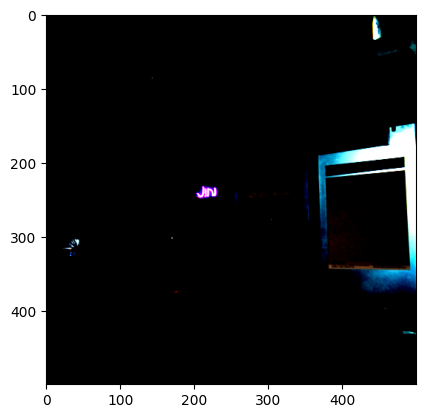

In [99]:
def predict_single(image, label, mask):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    show_example(image, prediction, mask)
predict_single(*val_dataset[1500])

In [101]:
val_dataset.im_path(1500)

'../data/test/blur/clear_gt/real_blur/gt_491.png'

In [ ]:
for i, data in enumerate(val_dataset):
    image = data[0]
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    pred_label = decode_target(prediction)
    tar_label = decode_target(data[1])
    if pred_label != tar_label:
        print(i)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: blur
mask: blur

tensor([9.9686e-01, 3.0953e-03, 8.0210e-05, 1.0463e-04], device='cuda:0',
       grad_fn=<SelectBackward0>)


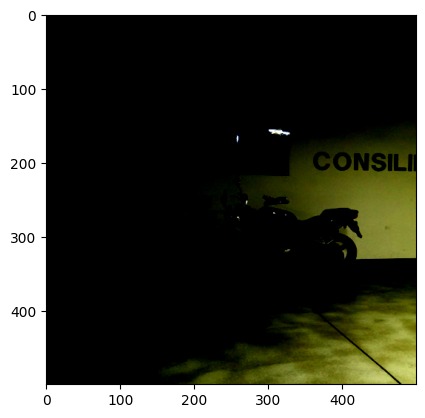

In [105]:
predict_single(*val_dataset[1258])

In [106]:
val_dataset.im_path(1258)

'../data/test/blur/clear_gt/real_blur/gt_273.png'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: clear
mask: blur

tensor([0., 0., 0., 0.])


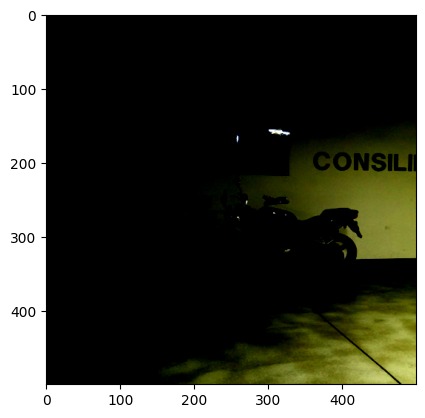

In [107]:
show_example(*val_dataset[1258])

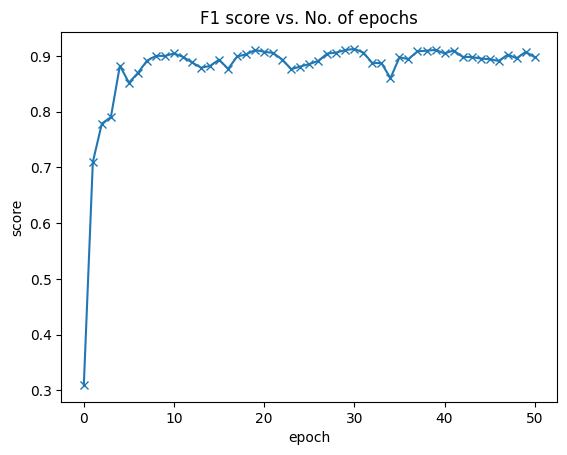

In [108]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');
plot_scores(history)

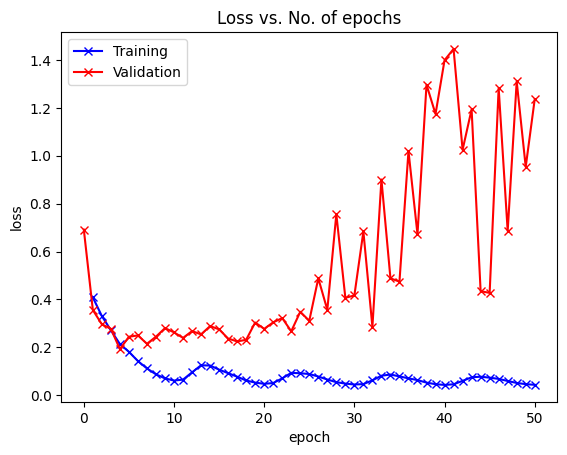

In [109]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

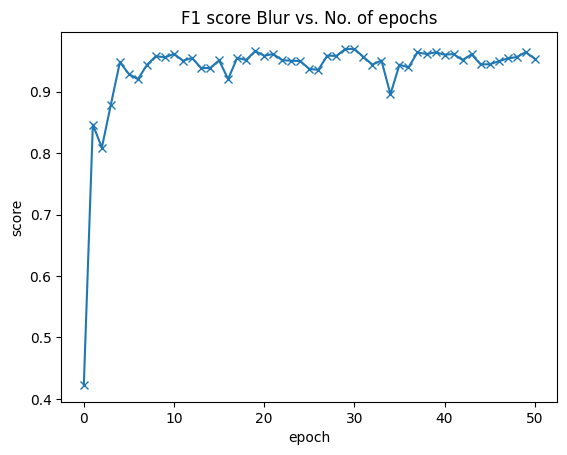

In [110]:
def plot_scores(history):
    scores = [x['val_score_blur'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Blur vs. No. of epochs');
plot_scores(history)

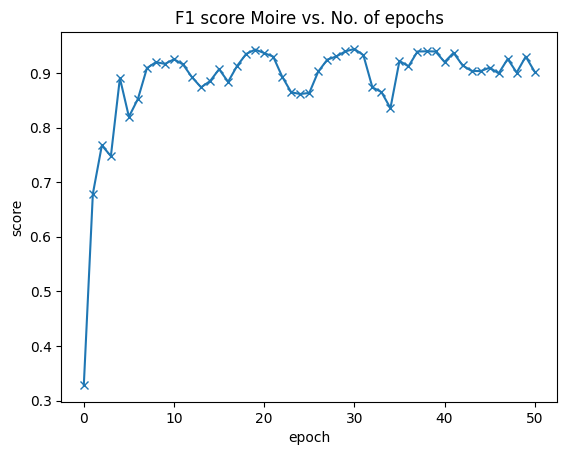

In [111]:
def plot_scores(history):
    scores = [x['val_score_demoir'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Moire vs. No. of epochs');
plot_scores(history)

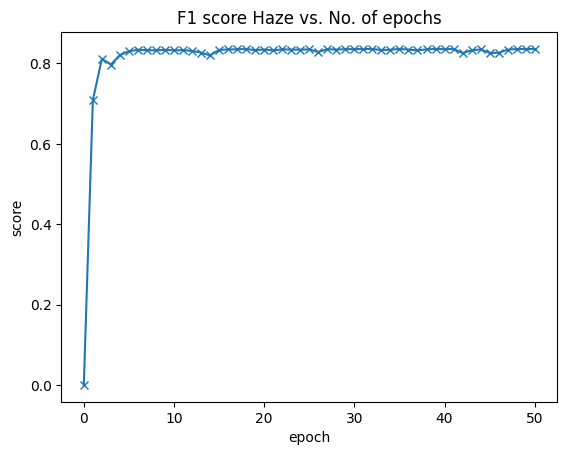

In [112]:
def plot_scores(history):
    scores = [x['val_score_haze'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Haze vs. No. of epochs');
plot_scores(history)

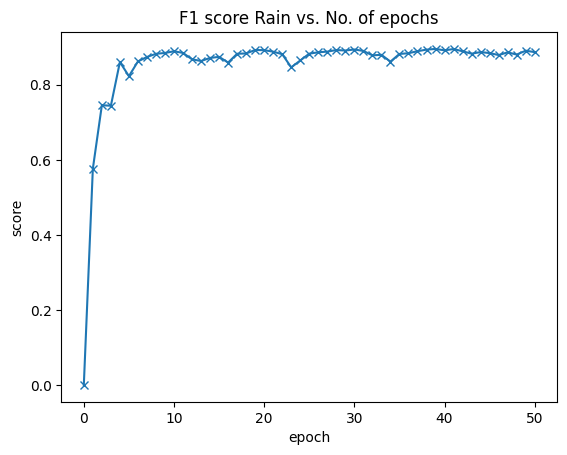

In [113]:
def plot_scores(history):
    scores = [x['val_score_rain'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Rain vs. No. of epochs');
plot_scores(history)

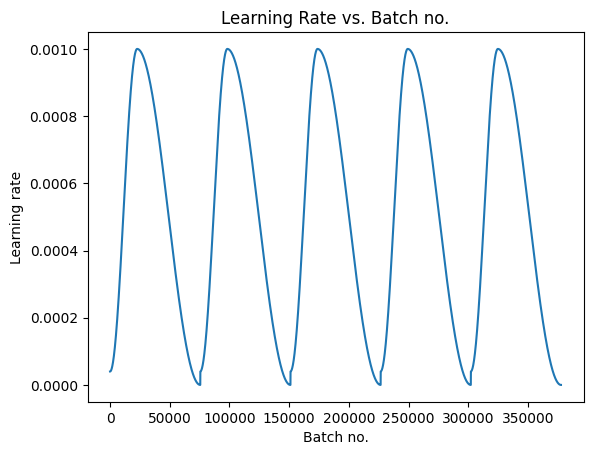

In [114]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)

In [115]:
def random_image_prediction(url): #This function is to see the predictions of random images from internet.
    image_url = requests.get(url, stream = True).raw
    image = Image.open(image_url)
    image_tensor = val_trans(image).unsqueeze(0)
    img = to_device(image_tensor, device)
    preds = model(img)
    prediction = preds[0]
    print("Prediction:")
    print("Tensor: ", prediction)
    print()
    print("Label:", decode_target(prediction))
    plt.imshow(image)

Prediction:
Tensor:  tensor([9.1135e-04, 4.7822e-03, 5.8287e-04, 9.9385e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: rain


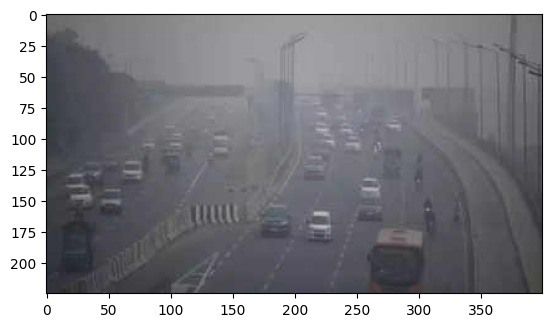

In [116]:
random_image_prediction('https://static.toiimg.com/thumb/msid-88217291,width-400,resizemode-4/88217291.jpg')

Prediction:
Tensor:  tensor([0.6633, 0.2855, 0.0127, 0.0191], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: blur


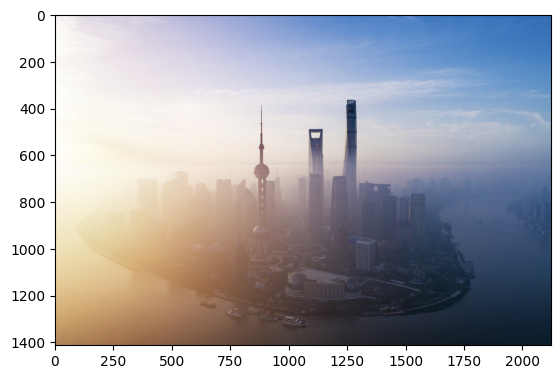

In [117]:
random_image_prediction('https://metro.co.uk/wp-content/uploads/2018/06/gettyimages-682966492.jpg?quality=90&strip=all')

Prediction:
Tensor:  tensor([0.1912, 0.2447, 0.0527, 0.5552], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: rain


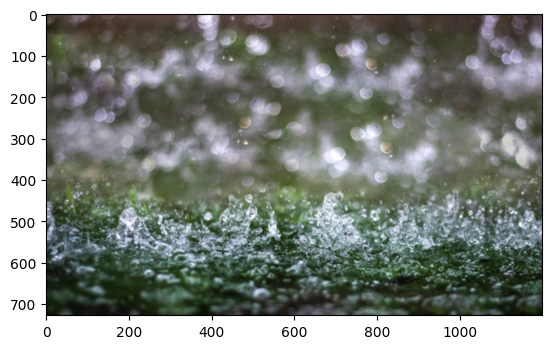

In [118]:
random_image_prediction('https://www.envirostraw.com.au/wp-content/uploads/2022/08/ES-rain-soil-01.jpg')

In [ ]:
show_example(*val_dataset[3280]) #checking out the predictions of some images from the validation dataset.

In [120]:
PATH = os.path.join('../saved_models', datetime.now().strftime('mobilenetv2_customBCE_new_metrics_clear_gt_not_pretrained_14_05_23.pt'))
torch.save(model.state_dict(), PATH)

In [ ]:
loaded_model = CustomModel().to(device)

In [ ]:
loaded_model.load_state_dict(torch.load('saved_models/mobilenetv2_customBCE_new_metrics_not_pretrained_13_05_23.pt'))

In [ ]:
loaded_model.to(device)

In [ ]:
loaded_model.eval()